In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from numba import njit

In [2]:
# 기본단위 m
points = 1000
UNIT = 1e10
WAVELENGTH = 670e-9 * UNIT
WAVENUMBER = 1 / WAVELENGTH * 2 * np.pi
GAP_DOUBLE_SLIT = {
  14: 356e-6 * UNIT,
  15: 406e-6 * UNIT,
  15: 457e-6 * UNIT,
}

def gpu_mul(A, B):
  A = th.tensor(A, dtype = th.complex128).to('mps')
  B = th.tensor(B, dtype = th.complex128).to('mps')
  return th.matmul(A, B).to('cpu').numpy()

@njit
def numba_mul(A, B):
  return A @ B

@njit
def numba_get_mul(distance_arr):
  return np.exp(1j * WAVENUMBER * distance_arr) / distance_arr

@njit
def numba_dist(A, B, distance):
  return np.sqrt(distance**2 + np.square(A - B))

class Hole:
  def __init__(self, position, width, points = 1000):
    self.position = position
    self.width = width
    self.position_arr = np.linspace(self.position - width / 2, self.position + width / 2, points).T
    self.field = np.zeros_like(self.position_arr, dtype = np.complex128)
  
  def set_field(self, field):
    self.field = field

def hole_to_hole(hole1, hole2, distance):
  field1 = hole1.field # n x 1
  position_arr1 = hole1.position_arr # n x 1
  position_arr2 = hole2.position_arr # m x 1

  # distance_arr = np.sqrt(distance**2 + np.square(position_arr1[np.newaxis, :] - position_arr2[:, np.newaxis])) # m x n
  distance_arr = numba_dist(position_arr1[np.newaxis, :], position_arr2[:, np.newaxis], distance)
  
  mul = numba_get_mul(distance_arr)
  # return field1 @ mul.T
  return numba_mul(field1, mul.T)

def hole_to_moving_hole(hole1, hole2, distance):
  field1 = hole1.field # n x 1
  position_arr1 = hole1.position_arr # n x 1
  position_arr2 = hole2.position_arr # m x k
  # distance_arr = np.sqrt(distance**2 + np.square(position_arr1[np.newaxis, :] - position_arr2[:, :, np.newaxis])) # m x k x n
  distance_arr = numba_dist(position_arr1[np.newaxis, :], position_arr2[:, :, np.newaxis], distance)

  mul = numba_get_mul(distance_arr)
  return np.sum(field1[np.newaxis, :] @ mul, axis = 2)

def field_to_intensity(field):
  return np.linalg.norm(field)**2

In [3]:
def simulate(slit_position, slit_type, blocker_position, detector_position):
  distance3 = 0.389 * UNIT

  gap = GAP_DOUBLE_SLIT[slit_type]
  slit_hole1 = Hole(slit_position, 85e-6 * UNIT)
  slit_hole2 = Hole(np.array(slit_position) + gap, 85e-6 * UNIT)

  distance2 = 0.009815 * UNIT
  blocker = Hole(blocker_position, 1778e-6 * UNIT, points = 1000)

  distance1 = 0.489 * UNIT
  
  detector = Hole(detector_position, 85e-6 * UNIT, points = 1)

  slit_hole1.set_field(np.ones_like(slit_hole1.field))
  slit_hole2.set_field(np.ones_like(slit_hole2.field))

  blocker.set_field(hole_to_hole(slit_hole1, blocker, distance2) + hole_to_hole(slit_hole2, blocker, distance2))
  detector.set_field(hole_to_hole(blocker, detector, distance1))

  # detector.set_field(hole_to_hole(slit_hole1, detector, distance1) + hole_to_hole(slit_hole2, detector, distance1))
  return field_to_intensity(detector.field)


In [4]:
n = 200
detector_position = np.linspace(-2e-3 * UNIT, 2e-3 * UNIT, n)
ans = []
for i in range(n):
  ans.append(simulate(0, 15, 0, detector_position[i]))

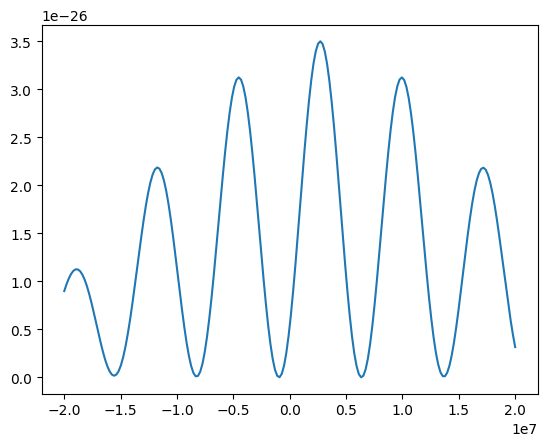

In [5]:
plt.plot(detector_position, ans)

In [75]:
slit_position = 0; slit_type = 15; blocker_position = 0; detector_position = 0
distance3 = 0.389 * UNIT

gap = GAP_DOUBLE_SLIT[slit_type]
slit_hole1 = Hole(slit_position, 85e-6 * UNIT)
slit_hole2 = Hole(np.array(slit_position) + gap, 85e-6 * UNIT)

distance2 = 0.009815 * UNIT
blocker = Hole(blocker_position, 1778e-6 * UNIT, points = 1000)

distance1 = 0.489 * UNIT

detector = Hole(detector_position, 85e-6 * UNIT, points = 1)

slit_hole1.set_field(np.ones_like(slit_hole1.field))
slit_hole2.set_field(np.ones_like(slit_hole2.field))

In [83]:
hole1 = slit_hole1; hole2 = blocker; distance = distance2
field1 = hole1.field # n x 1
position_arr1 = hole1.position_arr # n x 1
position_arr2 = hole2.position_arr # m x 1

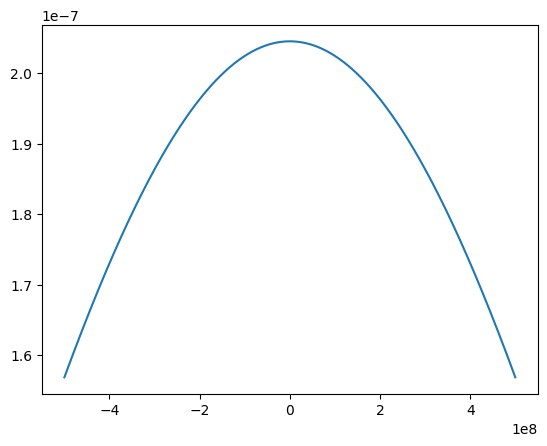

In [50]:
slit_position = 0
gap = 356e-6 * UNIT

slit_hole1 = Hole(slit_position, 85e-6 * UNIT, points=1000)
slit_hole2 = Hole(np.array(slit_position) + gap, 85e-6 * UNIT, points=1000)
slit_hole1.set_field(np.ones_like(slit_hole1.field))
slit_hole2.set_field(np.ones_like(slit_hole2.field))
goal = Hole(0, 10e-2 * UNIT, points=1000)

plt.plot(goal.position_arr, np.abs(hole_to_hole(slit_hole1, goal, 0.489 * UNIT)))

[[4.91545269e+08 4.91545278e+08 4.91545287e+08 ... 4.91553898e+08
  4.91553907e+08 4.91553915e+08]
 [4.91535106e+08 4.91535115e+08 4.91535123e+08 ... 4.91543718e+08
  4.91543726e+08 4.91543735e+08]
 [4.91524963e+08 4.91524971e+08 4.91524980e+08 ... 4.91533557e+08
  4.91533566e+08 4.91533574e+08]
 ...
 [4.91533574e+08 4.91533566e+08 4.91533557e+08 ... 4.91524980e+08
  4.91524971e+08 4.91524963e+08]
 [4.91543735e+08 4.91543726e+08 4.91543718e+08 ... 4.91535123e+08
  4.91535115e+08 4.91535106e+08]
 [4.91553915e+08 4.91553907e+08 4.91553898e+08 ... 4.91545287e+08
  4.91545278e+08 4.91545269e+08]]


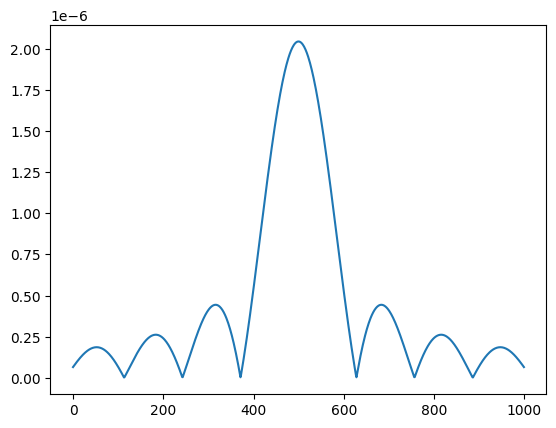

In [ ]:
hole1 = slit_hole1
hole2 = goal
distance = 0.489 * UNIT

field1 = hole1.field # n x 1
position_arr1 = hole1.position_arr # n x 1
position_arr2 = hole2.position_arr # m x 1
distance_arr = np.sqrt(distance**2 + np.square(position_arr1[np.newaxis, :] - position_arr2[:, np.newaxis])) # m x n
print(distance_arr)

mul = np.exp(1j * WAVENUMBER * distance_arr) / distance_arr
plt.plot(np.abs(field1 @ mul.T))

In [ ]:
(mul[0])

array([ 7.25528057e-04+6.88192476e-04j,  6.93519591e-04-7.20437660e-04j,
        7.68611293e-04+6.39715973e-04j, -5.82575897e-04+8.12776211e-04j,
        8.08461644e-04+5.88548736e-04j, -5.28666032e-04+8.48829825e-04j,
       -7.99701072e-04-6.00398234e-04j,  5.41116893e-04-8.40947295e-04j,
        8.77807532e-04+4.79013341e-04j,  4.85468152e-04-8.74254264e-04j,
        9.07011390e-04+4.21105904e-04j, -3.54547366e-04+9.35037972e-04j,
        9.32400234e-04+3.61427238e-04j, -2.93191976e-04+9.56053507e-04j,
       -9.74720456e-04-2.23427564e-04j, -2.30603381e-04+9.73047750e-04j,
       -9.87153268e-04-1.59775684e-04j, -1.67044835e-04+9.85949221e-04j,
       -9.95433977e-04-9.54517658e-05j,  2.33608646e-05-9.99727019e-04j,
       -9.99527755e-04-3.07263644e-05j, -4.14912023e-05-9.99138790e-04j,
        9.93538788e-04-1.13492370e-04j, -1.06168752e-04-9.94348047e-04j,
        9.84092661e-04-1.77655501e-04j,  2.48215682e-04+9.68704711e-04j,
       -9.86603721e-04+1.63134729e-04j, -2.33914005